This file will be used to try out the qiskit circuit cutting addon tutorials and other miscellaneous tests of the circuit cutting addon.

Test 1: Reducing circuit width. AKA. Optimally splitting a circuit into subcircuits.

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap
#from qiskit.primitives import StatevectorSampler as Sampler
from cutting_CompUncomp import cutting_CompUncomp
import numpy as np

In [15]:
NUM_QUBITS = 4

dataset = np.array([
    np.random.rand(NUM_QUBITS),
    np.random.rand(NUM_QUBITS)
])
print(dataset)

[[0.11284358 0.45216847 0.40814063 0.47970399]
 [0.57223138 0.24059019 0.64757746 0.89204366]]


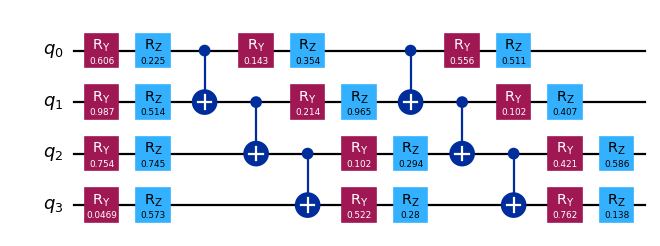

In [28]:
from qiskit.circuit.library import EfficientSU2

# set up an SU2 basic circuit with 4 qubits and linear entanglement.
qc = EfficientSU2(4, entanglement="linear", reps=2).decompose()
# set the angle of every rotation to be the parameter 0.4.
qc.assign_parameters(np.random.rand(len(qc.parameters)), inplace=True)

# draw the circuit.
qc.draw("mpl", scale=0.8)

Manual kernel parameters: ParameterView([])
[[0.11284358332333089, 0.45216847121114156, 0.408140627058282, 0.4797039907533439, 0.5722313778169084, 0.24059018878126337, 0.6475774622061474, 0.8920436601381377]]


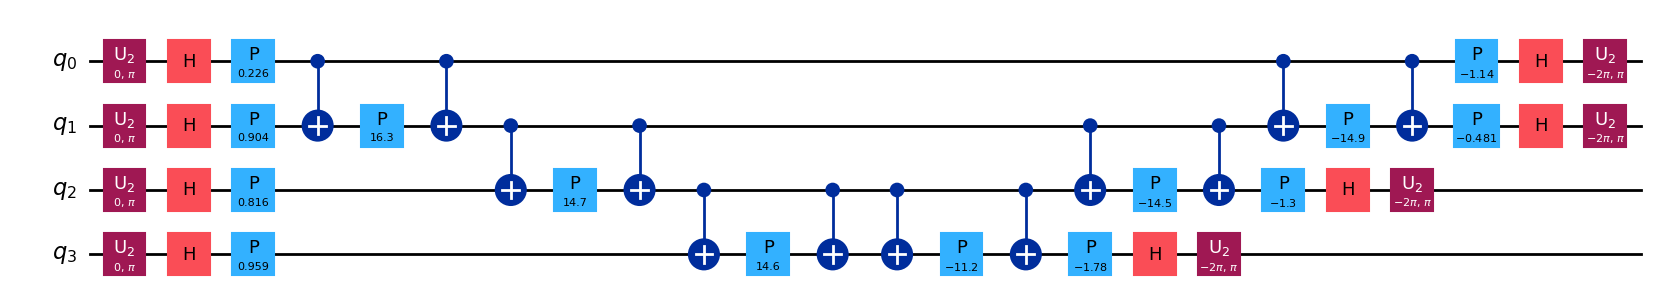

In [19]:
#generate circuit
#run this or above

from qiskit.primitives import StatevectorSampler as Sampler

fidelity_computer = cutting_CompUncomp(Sampler())


U_map = ZZFeatureMap(feature_dimension=NUM_QUBITS, reps=1, entanglement="linear")

manual_kernel = QuantumCircuit(NUM_QUBITS)

for i in range(NUM_QUBITS):
    manual_kernel.h(i)


manual_kernel = manual_kernel.compose(U_map)

manual_kernel = manual_kernel.decompose()

circuits = fidelity_computer._construct_circuits(manual_kernel, manual_kernel)

values = fidelity_computer._construct_value_list(manual_kernel, manual_kernel, dataset[0], dataset[1])

circuits[0].assign_parameters(values[0], inplace=True)

print(f'Manual kernel parameters: {circuits[0].parameters}')
print(values)
circuits[0].draw("mpl")

In [29]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_cutting import partition_problem

#Observables are self-adjoint operators. They map to real measurable quantities. Their eigenvalues are the possible measurement values.
# In Qiskit, we need to break down the operator into a linear combination of Pauli operator tensors.

observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])

# Define the partitioning request: supply a circuit to be partitioned, and observables to be mentioned
# on the subcircuits. If labels provided, partitions the circuit and the observables as is into the labelled subcircuits.
# Otherwise, smartly discovers a partition (into single qubit circuits? possibly).
partitioned_problem = partition_problem(
    circuit=qc, partition_labels="AABB", observables=observable.paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
#The bases mark where the cuts are in the circuit.
bases = partitioned_problem.bases

In [17]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_cutting import partition_problem

operator = fidelity_computer.generate_operator(circuits[0])

print(operator.paulis)

partitioned_problem = partition_problem(
    circuit=circuits[0], partition_labels="AABB", observables=operator.paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
#The bases mark where the cuts are in the circuit.
bases = partitioned_problem.bases

['IIII', 'IIIZ', 'IIZI', 'IIZZ', 'IZII', 'IZIZ', 'IZZI', 'IZZZ', 'ZIII',
 'ZIIZ', 'ZIZI', 'ZIZZ', 'ZZII', 'ZZIZ', 'ZZZI', 'ZZZZ']


In [30]:
subobservables

{'A': PauliList(['II', 'ZI', 'ZZ', 'XI', 'ZZ', 'IX']),
 'B': PauliList(['ZZ', 'IZ', 'II', 'XI', 'ZI', 'IX'])}

In [31]:
bases

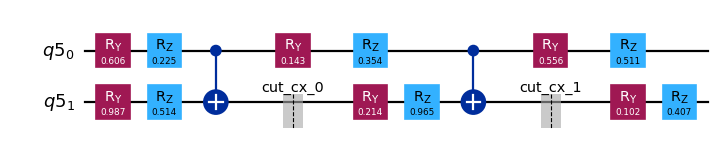

In [32]:
subcircuits['A'].draw("mpl", scale=0.8)

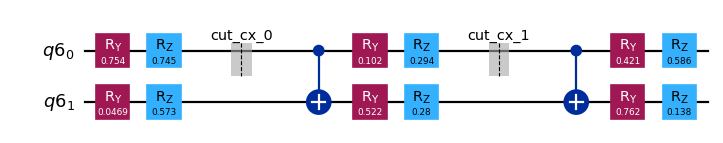

In [33]:
subcircuits['B'].draw("mpl", scale=0.8)

In [43]:
#To get the sampling overhead, we can use numpy and the bases.

import numpy as np

print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 282429536481.0


Generating the subexperiments from the subcircuits to be run

In [10]:
from qiskit_addon_cutting import generate_cutting_experiments

#Take in subcircuits and subobservables, and generate the appropriate subexperiments with their coefficients.
subexperiments, coefficients = generate_cutting_experiments(circuits=subcircuits, observables=subobservables, num_samples=np.inf)


In [11]:
#choose a backend to run the subexperiments

from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = FakeManilaV2()

In [12]:
#Prepare the subexperiments for the backend. Transpile the circuits accordingly.

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

#In this case, transpiles into ISA circuits
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}

Execution Step

In [13]:
#We run the experiments using Qiskit Runtime Sampler

from qiskit_ibm_runtime import SamplerV2, Batch

# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }

In [14]:
results = {label: job.result() for label, job, in jobs.items()}
#Results of each subcircuit.

Post-processing Step

In [16]:
#Next, we need to reconstruct the expectation value of our operator from the results of the various subexperiments.
# We use the coefficients to multiply the results for the observables and sum them.

from qiskit_addon_cutting import reconstruct_expectation_values

# Get exp val for each subobservable
reconstructed_expval_t = reconstruct_expectation_values(
    results, coefficients, subobservables,
)

#Get the final exp val for the observable.
reconstructed_expval = np.dot(reconstructed_expval_t, operator.coeffs)



In [19]:
#Estimate the actual observable and compare results with the DQC version.
from qiskit_aer.primitives import EstimatorV2

estimator = EstimatorV2()
exact_expval = estimator.run([(circuits[0], operator)]).result()[0].data.evs
print(f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 0.69012129
Exact expectation value: 1.0
Error in estimation: -0.30987871
Relative error in estimation: -0.30987871


Summary: Using this process, we can split a circuit into subcircuits using predetermined cuts, run the associated subcircuits/subexperiments, and knit the results together to get the expectation value of the observable we want.

Circuit Depth reduction using circuit cutting
This is done to reduce the number of swaps that are needed to put qubits that need to interact on "adjacent" physical qubits, and avoid extra swap gates by this routing.

In [ ]:
#Once again, step 1 is to create the circuit and assign an observable to be measured against.
from qiskit.circuit.library import EfficientSU2

circuit2 = EfficientSU2(num_qubits=4, entanglement="circular").decompose()
circuit2.assign_parameters([0.3] * len(circuit2.parameters), inplace=True)

from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])

circuit2.draw("mpl", scale=0.8)

In [ ]:
# Specify a backend.
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = FakeManilaV2()

In [ ]:
#Changes
# Next, in order to accurately gauge circuit depth and minimize the number of swaps done, we need to transpile the circuit.add_bits
# We choose a layout requiring 2 swaps to execute gates between 0 and 3 qubits and 2 swaps to return them to their original position

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend, initial_layout=[0, 1, 2, 3]
)

transpiled_qc = pass_manager.run(circuit2)
print(f"Transpiled circuit depth: {transpiled_qc.depth(lambda x: len(x[1]) >= 2)}")

In [ ]:
transpiled_qc.draw("mpl", scale=0.4, idle_wires=False, fold=-1)

In [ ]:
# Next, we want to decompose any gates between qubits 0 and 3, replacing their CNOT with a 2qubit QPD gate.

from qiskit_addon_cutting import cut_gates

# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(circuit2.data)
    if {circuit2.find_bit(q)[0] for q in instruction.qubits} == {0, 3}
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(circuit2, cut_indices)
#Cut gates can be used separately from partition problem! You can cut a gate without partitioning.

# Note that the circuit here isn't fully separated! The cutting tool is used to emulate the connection that specifically doesn't exist between 2 qubits.
qpd_circuit.draw("mpl", scale=0.8)

In [ ]:
#Generating subexperiments according to quantum Phase Decomposition.

import numpy as np
from qiskit_addon_cutting import generate_cutting_experiments

# Generate the subexperiments and sampling coefficients
subexperiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=observable.paulis, num_samples=np.inf
)

In [ ]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

In [ ]:
# We can transpile a randomly chosen subcircuit to the same layout to demonstrate that the circuit is shallower.
transpiled_qpd_circuit = pass_manager.run(subexperiments[100])

print(
    f"Original circuit depth after transpile: {transpiled_qc.depth(lambda x: len(x[1]) >= 2)}"
)
print(
    f"QPD subexperiment depth after transpile: {transpiled_qpd_circuit.depth(lambda x: len(x[1]) >= 2)}"
)
transpiled_qpd_circuit.draw("mpl", scale=0.8, idle_wires=False, fold=-1)

In [ ]:
# Transpile the subeperiments to the backend's instruction set architecture (ISA)
isa_subexperiments = pass_manager.run(subexperiments)

# We then execute the transpiled subexperiments and retrieve the results.clear
from qiskit_ibm_runtime import SamplerV2

# Set up the Qiskit Runtime Sampler primitive.  For a fake backend, this will use a local simulator.
sampler = SamplerV2(backend)

# Submit the subexperiments
job = sampler.run(isa_subexperiments)

# Retrieve the results
results = job.result()

In [ ]:
# post-processing step

from qiskit_addon_cutting import reconstruct_expectation_values

reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    observable.paulis,
)
# Reconstruct final expectation value
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)

In [ ]:
from qiskit_aer.primitives import EstimatorV2

estimator = EstimatorV2()
exact_expval = estimator.run([(circuit2, observable)]).result()[0].data.evs
print(f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Note: These implicates that the act of distribution (QPD) introduces error into the expectation value even in the best case - there will be significant error introduced to the outcome and thus the accuracy of any predictive model.

Wire Cutting
Another way to  split circuits into distributable subcircuits using circuit cutting is to use wire-cutting. This follows the same qiskit pattern.

A wire cut is essentially MOVE-ing a quantum state from one qubit to another(resetting the incoming data on the second qubit and using a SWAP operator).

In [ ]:
# Mapping a quantum circuit. We map a different problem here.

import numpy as np
from qiskit import QuantumCircuit

qc_0 = QuantumCircuit(7)
for i in range(7):
    qc_0.rx(np.pi / 4, i)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)
qc_0.cx(3, 4)
qc_0.cx(3, 5)
qc_0.cx(3, 6)
qc_0.cx(0, 3)
qc_0.cx(1, 3)
qc_0.cx(2, 3)

from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["ZIIIIII", "IIIZIII", "IIIIIIZ"])

qc_0.draw("mpl")

In [ ]:
# Step 2 - Optimize

from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["ZIIIIII", "IIIZIII", "IIIIIIZ"])

#in this case, we can introduce an additional qubit for the operations and 
# manually put 2 move operations on qubit 3 at the obvious locations.

In [ ]:
from qiskit_addon_cutting.instructions import Move

qc_1 = QuantumCircuit(8)
for i in [*range(4), *range(5, 8)]:
    qc_1.rx(np.pi / 4, i)
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)
qc_1.append(Move(), [3, 4])
qc_1.cx(4, 5)
qc_1.cx(4, 6)
qc_1.cx(4, 7)
qc_1.append(Move(), [4, 3])
qc_1.cx(0, 3)
qc_1.cx(1, 3)
qc_1.cx(2, 3)

qc_1.draw("mpl")

In [ ]:
# the newly introduced qubit 4 need to be accounted for in the observable.
observable_expanded = SparsePauliOp(["ZIIIIIII", "IIIIZIII", "IIIIIIIZ"])

In [ ]:
#We can then use the partition problem function again to separate the circuits into 2 circuits.

from qiskit_addon_cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc_1, partition_labels="AAAABBBB", observables=observable_expanded.paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

#Visualization
subobservables

In [ ]:
subcircuits["A"].draw("mpl")

In [ ]:
subcircuits["B"].draw("mpl")

In [ ]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

In [ ]:
#Next, we again generate the subexperiments to be run and choose the backend. We also transpile
#the circuit.
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)

from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = FakeManilaV2()

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Transpile the subexperiments to ISA circuits
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}

In [ ]:
#Execute the wire-cut subcircuits.

from qiskit_ibm_runtime import SamplerV2, Batch

# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }


# Retrieve results
results = {label: job.result() for label, job in jobs.items()}



In [ ]:
#Post-processing step - reconstruct values.

from qiskit_addon_cutting import reconstruct_expectation_values

reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)

from qiskit_aer.primitives import EstimatorV2

estimator = EstimatorV2()
exact_expval = estimator.run([(qc_0, observable)]).result()[0].data.evs
print(f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Automatically finding cuts

In [ ]:
# We map a random circuit for demonstration purposes.

import numpy as np
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp

circuit = random_circuit(7, 6, max_operands=2, seed=1242)
observable = SparsePauliOp(["ZIIIIII", "IIIZIII", "IIIIIIZ"])


circuit.draw("mpl", scale=0.8)

In [ ]:
# Optimize
#Find cut locations, given a maximum of 4 qubits per subcircuit. This circuit can be separated 
# in two by making a single wire cut and cutting one CRZGate.

from qiskit_addon_cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)

# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=4)

cut_circuit, metadata = find_cuts(circuit, optimization_settings, device_constraints)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.\n'
    f'Lowest cost solution found: {metadata["minimum_reached"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at circuit instruction index {cut[1]}")
cut_circuit.draw("mpl", scale=0.8, fold=-1)

In [ ]:
# add ancillas.
from qiskit_addon_cutting import cut_wires, expand_observables

qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observable.paulis, circuit, qc_w_ancilla)
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1)


In [ ]:
# partition circuit and observables.
from qiskit_addon_cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc_w_ancilla, observables=observables_expanded
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
print(
    f"Sampling overhead: {np.prod([basis.overhead for basis in partitioned_problem.bases])}"
)

In [ ]:
subcircuits[0].draw("mpl", style="iqp", scale=0.8)

In [ ]:
subcircuits[1].draw("mpl", style="iqp", scale=0.8)

In [ ]:
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=1_000
)
print(
    f"{len(subexperiments[0]) + len(subexperiments[1])} total subexperiments to run on backend."
)

In [ ]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = FakeManilaV2()

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Transpile the subexperiments to ISA circuits
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}

In [ ]:
# Execute

from qiskit_ibm_runtime import SamplerV2, Batch

# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }

len(jobs)

In [ ]:
# Retrieve results
results = {label: job.result() for label, job in jobs.items()}